In [2]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

In [3]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

In [4]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

In [5]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [6]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [7]:
32*32*3

3072

In [8]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image
combined = np.dstack((red,green,blue))

In [9]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

In [99]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

In [12]:
dataset_train[b'fine_labels'][0]

19

In [13]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


In [16]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


In [17]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


In [18]:
plt.imsave("file.png", test_image)

In [19]:
import pandas as pd

for index, label in enumerate(dataset_meta[b'fine_label_names']):
    if label in [b'bicycle',b'motorcycle']:
        print( f"Label Name: {label},  Label Number: {index}")

Label Name: b'bicycle',  Label Number: 8
Label Name: b'motorcycle',  Label Number: 48


In [20]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train.loc[df_train["labels"].isin([8,48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test.loc[df_test["labels"].isin([8,48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [24]:
df_train

,filenames,labels,row
16,bike_s_000682.png,8,16
30,bike_s_000127.png,8,30
130,cycle_s_002598.png,8,130
152,minibike_s_000824.png,48,152
195,motorcycle_s_001856.png,48,195
...,...,...,...
49578,velocipede_s_000010.png,8,49578
49588,motorcycle_s_001247.png,48,49588
49882,motorcycle_s_000724.png,48,49882
49962,velocipede_s_001637.png,8,49962


In [25]:
!mkdir ./train
!mkdir ./test

In [27]:
import os
def save_images(image_data_row_num , image_filename, target_folder_path, images_dataset):
    #Grab the image data in row-major form
    img = images_dataset[b'data'][image_data_row_num]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img[0:1024].reshape(32,32),
        img[1024:2048].reshape(32,32),
        img[2048:].reshape(32,32)
    ))
    
    try:
        image_file_path = os.path.join( target_folder_path, image_filename)
        plt.imsave(image_file_path, target)
    except e:
        return f"Error Saving {image_filename} to folder {target_folder_path} \n Error: {e}  "
    # Return any signal data you want for debugging
    return f"Successfully saved {image_filename} to folder {target_folder_path}."

for df_row in df_train.itertuples():
    print(save_images(df_row.row, df_row.filenames,"./train", dataset_train))

for df_row in df_test.itertuples():
    print(save_images(df_row.row, df_row.filenames,"./test", dataset_test))

Successfully saved bike_s_000682.png to folder ./train.
Successfully saved bike_s_000127.png to folder ./train.
Successfully saved cycle_s_002598.png to folder ./train.
Successfully saved minibike_s_000824.png to folder ./train.
Successfully saved motorcycle_s_001856.png to folder ./train.
Successfully saved bicycle_s_000537.png to folder ./train.
Successfully saved moped_s_000169.png to folder ./train.
Successfully saved motorcycle_s_001453.png to folder ./train.
Successfully saved safety_bike_s_000482.png to folder ./train.
Successfully saved dirt_bike_s_000124.png to folder ./train.
Successfully saved minibike_s_001863.png to folder ./train.
Successfully saved minibike_s_001177.png to folder ./train.
Successfully saved motorcycle_s_001792.png to folder ./train.
Successfully saved minibike_s_001969.png to folder ./train.
Successfully saved velocipede_s_001585.png to folder ./train.
Successfully saved moped_s_000035.png to folder ./train.
Successfully saved bike_s_000256.png to folder

In [28]:
import sagemaker

session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-413527149984
AWS Region: us-east-1
RoleArn: arn:aws:iam::413527149984:role/service-role/AmazonSageMaker-ExecutionRole-20231022T211523


In [29]:
# import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000017.png
upload: train/bicycle_s_000147.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000147.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000038.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000021.png
upload: train/bicycle_s_000124.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000124.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000035.png
upload: train/bicycle_s_000180.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000180.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000051.png
upload: train/bicycle_s_000066.png to s3://sagemaker-us-east-1-413527149984/train/bicycle_s_000066.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-4135271499

MODEL TRAINING

In [30]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

In [31]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

In [32]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve(framework= "image-classification", region = region, version="latest")
s3_output_location = f"s3://{bucket}/models/image_model"

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [33]:
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri = algo_image,
    role= role,
    instance_count = 1,
    instance_type = 'ml.p2.xlarge',
    output_path = s3_output_location,
    sagemaker_session = sagemaker.Session()   
)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [34]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32', 
    num_classes=2, 
    num_training_samples=df_train.shape[0] 
)

In [35]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

In [36]:
img_classifier_model.fit(model_inputs)

INFO:sagemaker:Creating training-job with name: image-classification-2023-10-22-16-24-03-222


2023-10-22 16:24:03 Starting - Starting the training job......
2023-10-22 16:24:40 Starting - Preparing the instances for training...............
2023-10-22 16:27:12 Downloading - Downloading input data...
2023-10-22 16:28:02 Training - Downloading the training image...........................
2023-10-22 16:32:13 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Oct 22 16:33:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute

In [37]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture = True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

In [38]:
deployment = img_classifier_model.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2023-10-22-16-45-49-138
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-10-22-16-45-49-138
INFO:sagemaker:Creating endpoint with name image-classification-2023-10-22-16-45-49-138


--------------!image-classification-2023-10-22-16-45-49-138


In [41]:
from sagemaker.predictor import Predictor
predictor = Predictor(endpoint)

In [75]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_000479.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload, initial_args={'ContentType': 'application/x-image'})## TODO: Process the payload with your predictor

In [76]:
print(inference)

b'[0.019429592415690422, 0.980570375919342]'


In [94]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix = "test")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-413527149984", "s3_key": "test/velocipede_s_000369.png"}'

In [73]:
from sagemaker.s3 import S3Downloader

data_path = "s3://sagemaker-us-east-1-413527149984/data_capture/image-classification-2023-10-22-16-45-49-138/AllTraffic/2023/10/22/16/54-15-528-920acec6-e1d0-431e-86fd-45fc4e7560cd.jsonl"## TODO: fill in the path to your captured data

S3Downloader.download(data_path, "captured_data")


['captured_data/54-15-528-920acec6-e1d0-431e-86fd-45fc4e7560cd.jsonl']

In [74]:
data_path = "s3://sagemaker-us-east-1-413527149984/data_capture/image-classification-2023-10-22-16-45-49-138/AllTraffic/2023/10/22/18/36-26-278-12b22d4e-8f46-4cbe-9524-aa103fa9d645.jsonl"## TODO: fill in the path to your captured data

S3Downloader.download(data_path, "captured_data")

['captured_data/36-26-278-12b22d4e-8f46-4cbe-9524-aa103fa9d645.jsonl']

In [84]:
data_path = "s3://sagemaker-us-east-1-413527149984/data_capture/image-classification-2023-10-22-16-45-49-138/AllTraffic/2023/10/22/18/40-17-235-464a6897-6a7d-4a31-a697-94dc381d219c.jsonl"## TODO: fill in the path to your captured data

S3Downloader.download(data_path, "captured_data")

['captured_data/40-17-235-464a6897-6a7d-4a31-a697-94dc381d219c.jsonl']

In [47]:
!pip install jsonlines
import jsonlines

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [85]:
import os

file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    file_path = os.path.join("./captured_data", jsonl)  # Construct the full file path
    if os.path.isfile(file_path): 
        with jsonlines.open(f"./captured_data/{jsonl}") as f:
            json_data.append(f.read())

In [86]:
json_data

[{'captureData': {'endpointInput': {'observedContentType': 'application/x-image',
    'mode': 'INPUT',
    'data': 'iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAB9dJREFUWIXNl0mTXEcRx3+ZVe/1Oj37PhpZMpblCCRADoMD4+DEgQjgc/Ax/CXgwIkLFw7czAWzhDFrYOMIZAnJCmsZaUaz9PQ23a/fUpUceowMhG8Yky8qKiIPlZn/f1W+/IuZGZ+jKYCZwf8yDTuPCfhnvlkS8tnE+1STz5sC/+Ev3iZWATVBRVBVEBARQBAxRA1BZj5VjPivpxgIAhjPyglEjGgJFgNQYEGxqGCGmaHOIT+89k0ThESURBypOpxzqCpOHc4rzinOOUQUVcX+jScREIMQIhYjJuBDoIrGQB15rJAqQ8pIVUVCCLMVAz5MBzhx4ByoBxRxDtHzPSao9zjzqCpiihN9VroBAtEMQpi5BFwVyULFkyojKCyLUAslGipCVWFVhYaAj+fQmihBhMIJwSlOFXWK90pUT3QOp+fIODereIY60SJRgCTFMEIITKxgOD/Hg0lFv9vlBRK2ZYYuZjPCRPD1SlEVUhMSp3gczhR1DofiTXF1T0xTpiFAhAMtaOHYrFIcRqVKiFD6SD0IVeU46dQ5nXNsxJIlGbOmCXOmkFdU0REqiBE0OCMoVGoEtRmZaqgaohAkUM0lLL3+JW6tKW/GAz4o+vRDSZUoeEEcoBGlpFGVSIyUi00Osj6tszFXG23aGKKCndP18acfXyKYNQczO38JggE1U5rDguzWQ9JhTqfW4OXmBs/rHAGjJCIxkErFQgW1AFjB0mTKjbllGhjTfEoaFY3PeoKdB/XRDD3PiE9kIyIoQu6hIsDeU3aaKVdfvEL6

In [89]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[1])

([0.9273874163627625, 0.07261252403259277], '2023-10-22T16:54:15Z')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


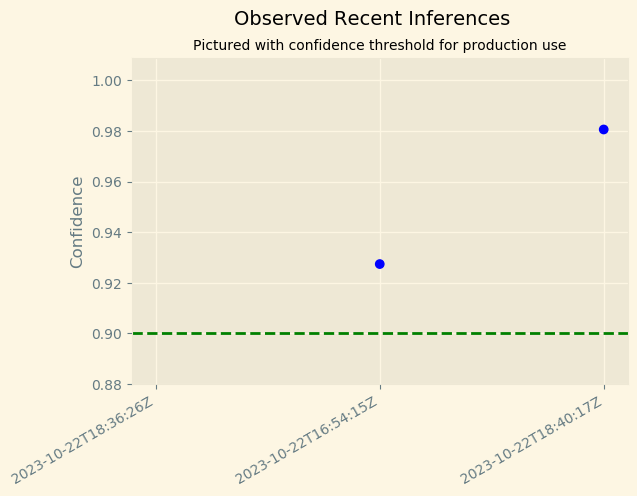

In [88]:
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)


plt.scatter(x, y, c=['r' if k<.9 else 'b' for k in y ])
plt.axhline(y=0.9, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()
plt.show()

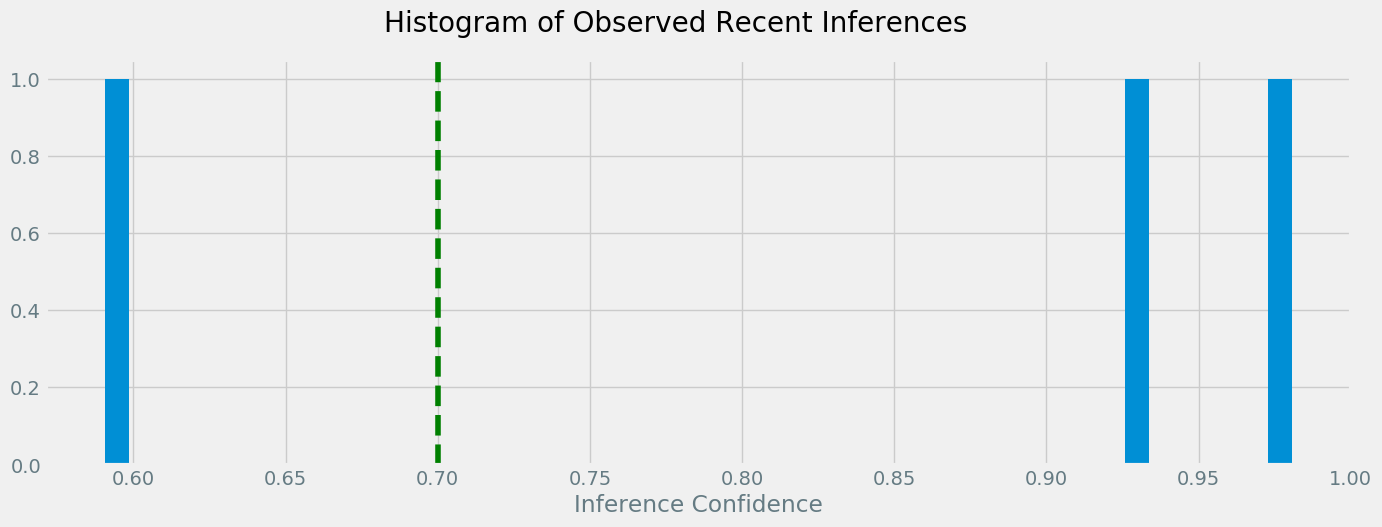

In [102]:
# Plot the histogram data
plt.figure(figsize=(15,5))
plt.hist(y, bins=50)
plt.axvline(x=0.70, color='green', linestyle='--')

# Add labels
plt.xlabel("Inference Confidence")
plt.suptitle("Histogram of Observed Recent Inferences", size=20)
plt.style.use("fivethirtyeight")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


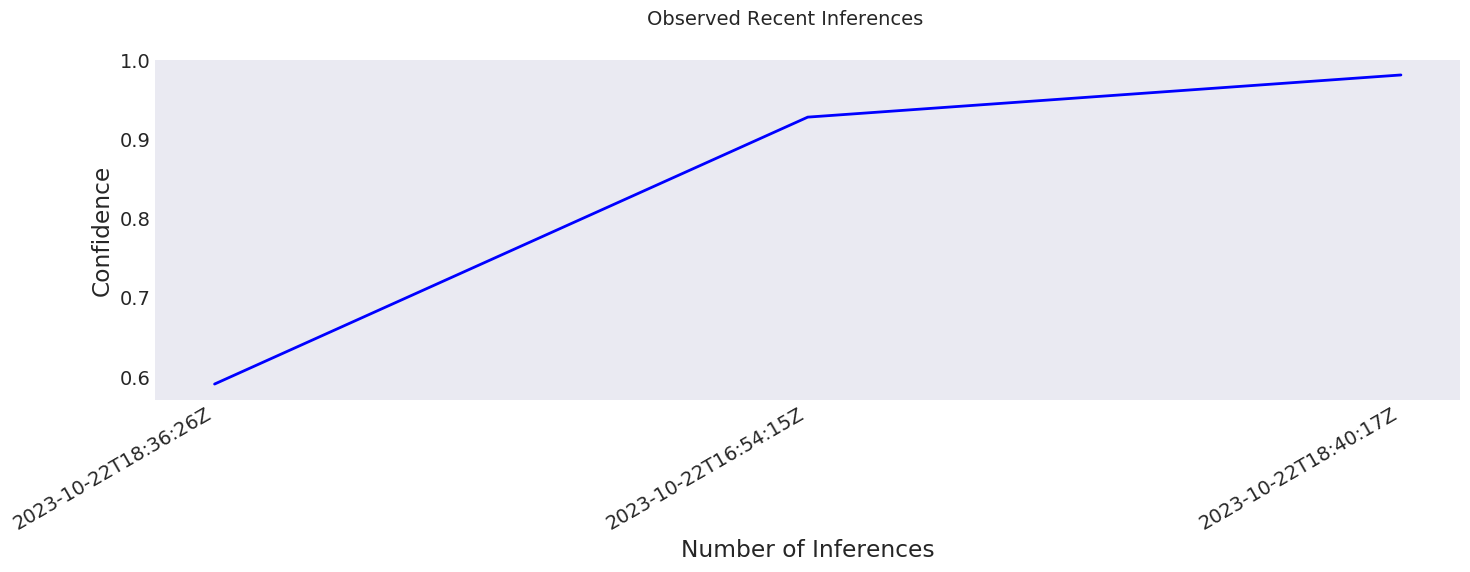

In [106]:
plt.figure(figsize=(15,5))
plt.plot(x, y, lw = 2, color = 'blue', alpha = 1)    
plt.suptitle("Observed Recent Inferences", size=14)
plt.xlabel("Number of Inferences")
plt.ylabel("Confidence")
plt.style.use( 'seaborn-dark')
plt.gcf().autofmt_xdate()
plt.show()